In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import cartopy.feature as feature

In [2]:
date_str = "20240705"

sst_file = "sst_data/sst_"+date_str

sst_ds = xr.open_dataset(sst_file, engine='netcdf4')
sst_ds =  sst_ds.squeeze()

#--- Convert from C to K
sst_ds.sst.values = sst_ds.sst.values+273.15

#--- Fill the nan values with zero
#sst_ds = sst_ds.sst.fillna(0)

In [3]:

#--- Gulf Stream
latitude_north = 51
latitude_south = 30
longitude_west = -80
longitude_east = -55

region_name = "gulf_stream"

sst_ds = sst_ds.sel(lat=slice(latitude_north,latitude_south,-1), lon=slice(longitude_west+360,longitude_east+360))

/var/folders/pd/x01_y6d52zj47w6_m5_h_8f80000gr/T/ipykernel_55478/572813943.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


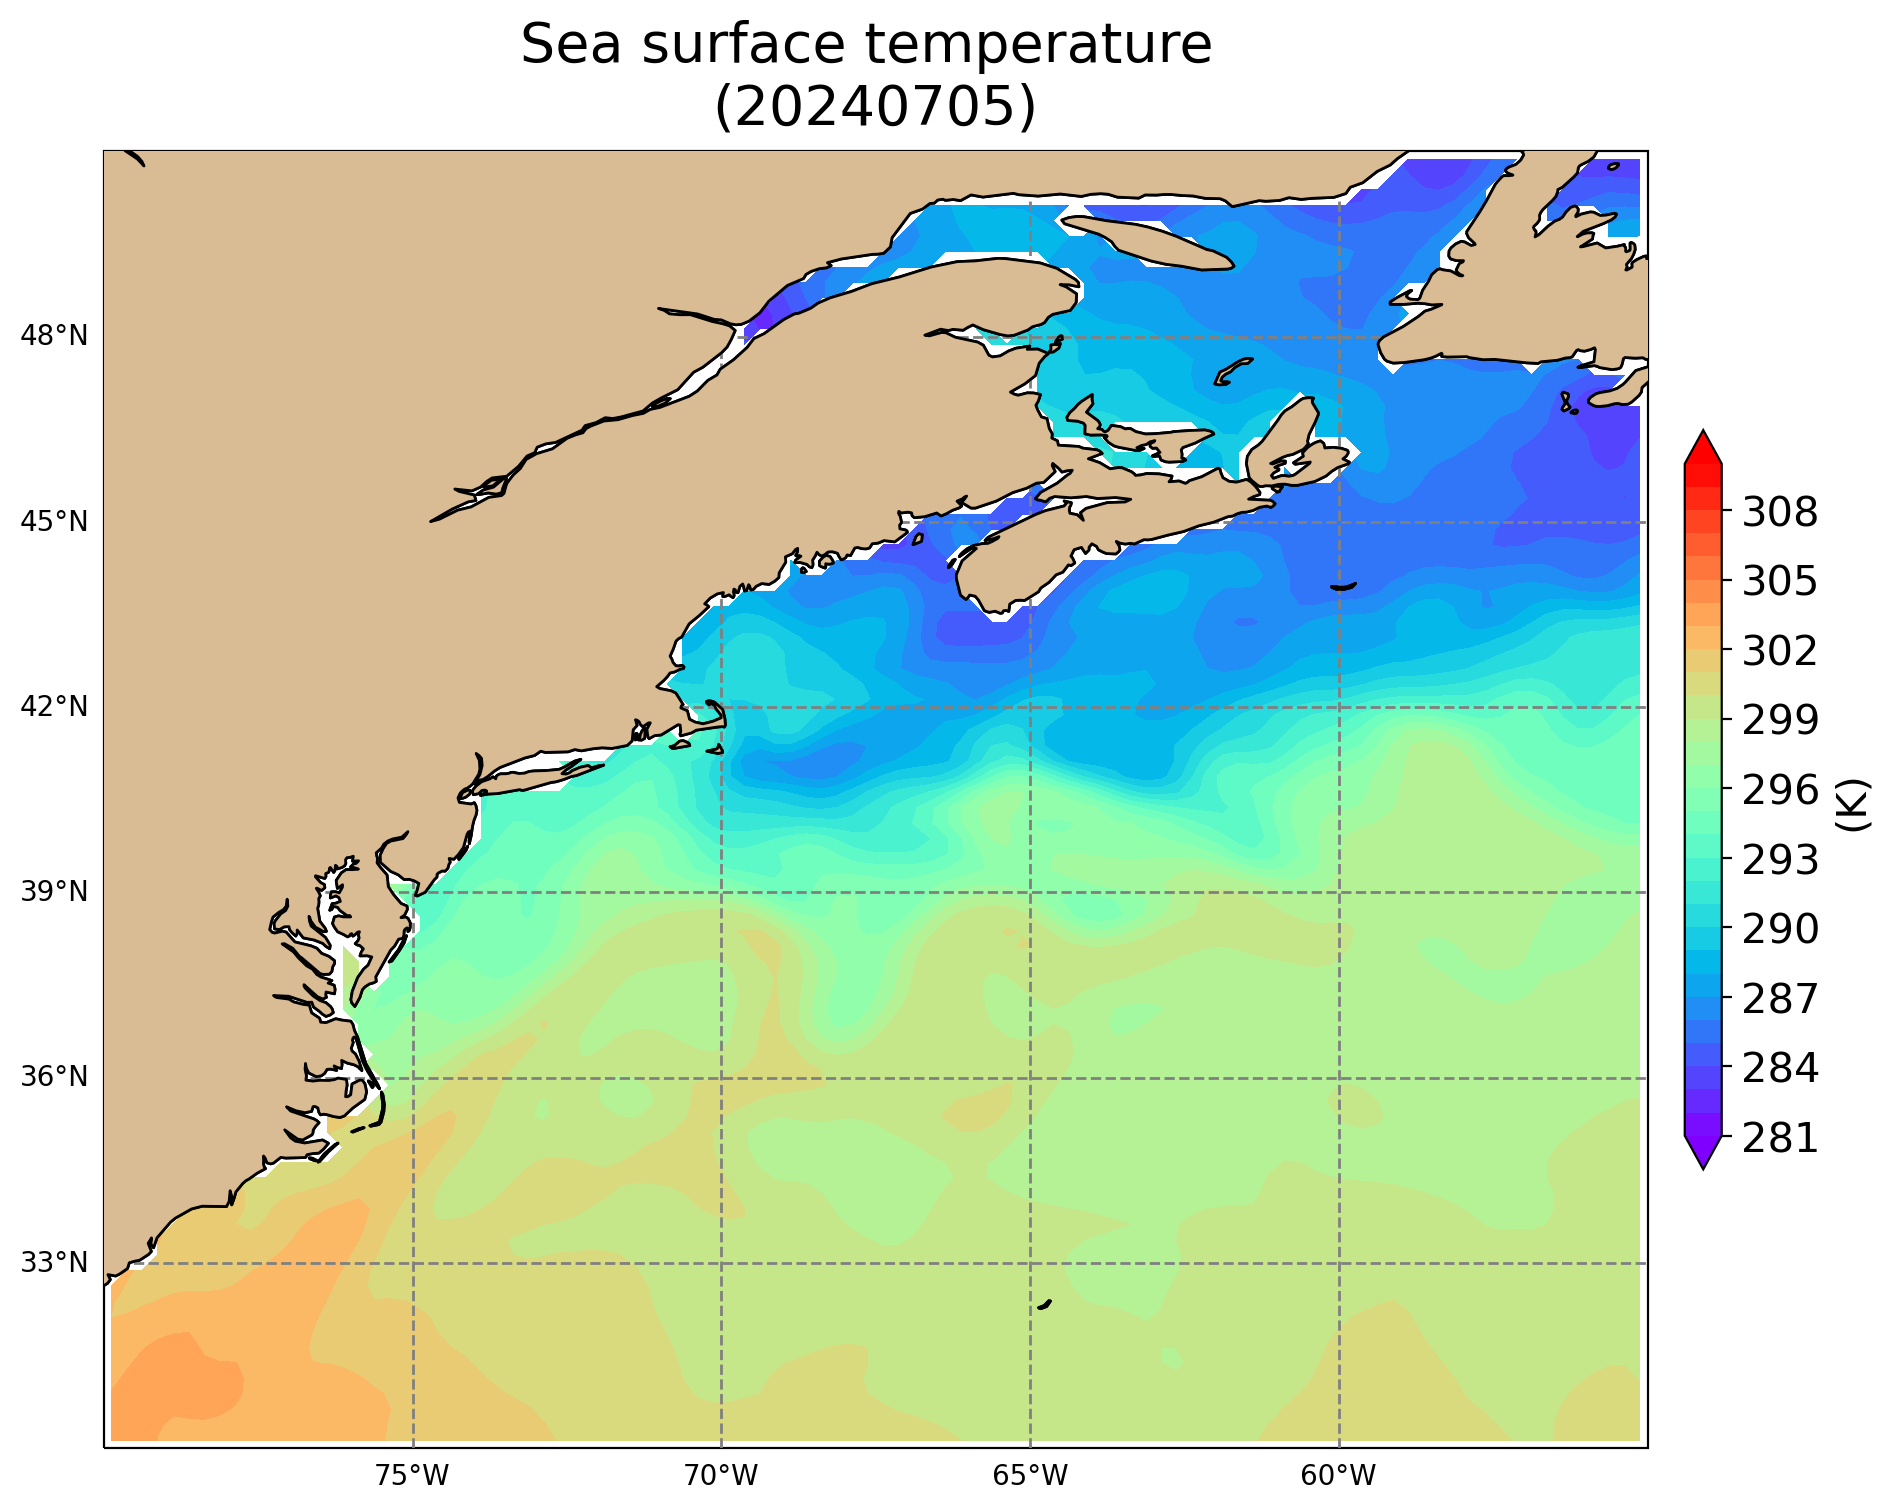

In [4]:
projection=ccrs.PlateCarree(central_longitude=0)
fig,ax=plt.subplots(1, figsize=(12,12),subplot_kw={'projection': projection})

levels = np.linspace(281, 310, 30)
cmap = plt.get_cmap('rainbow')

c=ax.contourf(sst_ds.lon, sst_ds.lat, sst_ds['sst'].values, cmap=cmap, extend='both', levels=levels)

clb = plt.colorbar(c, shrink=0.4, pad=0.02, ax=ax, extend='both')
clb.ax.tick_params(labelsize=15)
clb.set_label('(K)', fontsize=15)

ax.set_extent([longitude_west, longitude_east, latitude_south, latitude_north], crs=ccrs.PlateCarree())

ax.set_title("Sea surface temperature \n("+date_str[:10]+")", fontsize=20, pad=10)
ax.coastlines(resolution='50m', color='black', linewidth=1)

#--- Land in tan
ax.add_feature(feature.LAND, zorder=100, edgecolor='#000', facecolor='#DABC94')

#--- Lat and Lon lines
gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', linestyle='--', zorder=5)
gl.top_labels = False
gl.right_labels = False

ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f'{x:.1f}°E' if x >= 0 else f'{-x:.1f}°W'))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos: f'{y:.1f}°N' if y >= 0 else f'{-y:.1f}°S'))


fig.set_dpi(200)
fig.show()